In [1]:
# Basic lib imports
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import collections
from scipy import stats
import seaborn as sns
import pickle
%matplotlib inline

/data/chamal/projects/nikhil/code/python/conda/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Datasets and subject counts
* **ADNI1:**  
    bl,CN: 229
    bl,EMCI: 0
    bl,LMCI: 398
    m06,CN: 220
    m06,EMCI: 0
    m06,LMCI: 381
    m12,CN: 212
    m12,EMCI: 0
    m12,LMCI: 358
    m18,CN: 211
    m18,EMCI: 0
    m18,LMCI: 326
    m24,CN: 203
    m24,EMCI: 0
    m24,LMCI: 303
    m36,CN: 187
    m36,EMCI: 0
    m36,LMCI: 260
    total number of subjects: 3288

* **ADNI2:**
    bl,CN: 187
    bl,EMCI: 181
    bl,LMCI: 164
    m06,CN: 178
    m06,EMCI: 159
    m06,LMCI: 157
    m12,CN: 175
    m12,EMCI: 163
    m12,LMCI: 150
    m18,CN: 164
    m18,EMCI: 130
    m18,LMCI: 134
    m24,CN: 155
    m24,EMCI: 132
    m24,LMCI: 123
    m36,CN: 7
    m36,EMCI: 36
    m36,LMCI: 22
    total number of subjects: 2417

* **AIBL:**
    bl,1: 609
    bl,2: 143
    bl,3: 105
    m18,1: 172
    m18,2: 34
    m18,3: 55
    m36,1: 144
    m36,2: 30
    m36,3: 46
    m54,1: 108
    m54,2: 18
    m54,3: 15
    total number of subjects: 1479

In [322]:
#AIBL
#baseline_dir = '/projects/nikhil/AIBL/Data_extract_3.2.5/'
baseline_dir = '/data/chamal/projects/nikhil/data/trajectory_prediction/AIBL/Data_extract_3.2.5/'
demo_file = 'aibl_ptdemog_28-Apr-2015.csv'
mmse_file = 'aibl_mmse_28-Apr-2015.csv'
neurobat_file = 'aibl_neurobat_28-Apr-2015.csv'
dx_file = 'aibl_pdxconv_28-Apr-2015.csv'
registry_file = 'aibl_registry_28-Apr-2015.csv'
subject_tp_count_file = 'aibl_idx_sorted.txt'

aibl_demo_data = pd.read_csv(baseline_dir + demo_file)
mmse_data = pd.read_csv(baseline_dir + mmse_file)
neurobat_data = pd.read_csv(baseline_dir + neurobat_file)
dx_data = pd.read_csv(baseline_dir + dx_file)
reg_data = pd.read_csv(baseline_dir + registry_file)
subject_tp_count_data = pd.read_csv(baseline_dir + subject_tp_count_file, delim_whitespace=True, header=None)

#ADNI (for comparison)
adnimerge_file = '/data/chamal/projects/nikhil/data/trajectory_prediction/adni2/ADNIMERGE.csv'
adnimerge_data = pd.read_csv(adnimerge_file)

In [320]:
# Count subjects per timepoint
timepoints = ['bl','m18','m36','m54']
Dx_cat = [1,2,3]
count = []
for vis in timepoints:
    for dx in Dx_cat:
        data_slice = dx_data[(dx_data.VISCODE == vis) & (dx_data.DXCURREN == dx)]
        count.append(len(data_slice))
        print '{},{}: {}'.format(vis,dx,len(data_slice))
                     
print 'total number of subjects: {}'.format(np.sum(np.array(count)))

bl,1: 609
bl,2: 143
bl,3: 105
m18,1: 172
m18,2: 34
m18,3: 55
m36,1: 144
m36,2: 30
m36,3: 46
m54,1: 108
m54,2: 18
m54,3: 15
total number of subjects: 1479


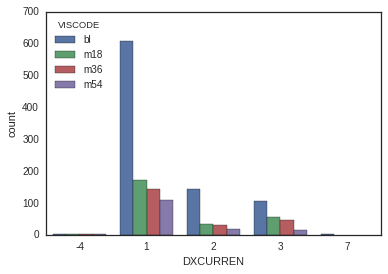

In [4]:
# Plot distributions
sns.set_style("white")
#plt.hist(dx_data.DXCURREN.values)
#sns.distplot(dx_data.DXCURREN)
sns.countplot(x='DXCURREN',hue='VISCODE', data=dx_data)

530


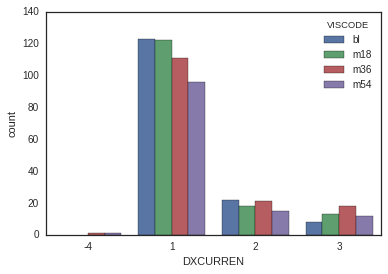

In [5]:
subject_tp_count_data.columns = ['count', 'RID']
tp_3plus_rid = subject_tp_count_data[subject_tp_count_data['count']>2].RID.values
dx_data_tp_3plus = dx_data[dx_data.RID.isin(tp_3plus_rid)]
print len(dx_data_tp_3plus[dx_data_tp_3plus['DXCURREN']!=3])
sns.countplot(x='DXCURREN',hue='VISCODE', data=dx_data_tp_3plus)

In [333]:
from collections import defaultdict
def create_longitudinal_CS_df(demo_data, dx_col, cs_data, cs_scale, col_list_feat, timepoints, keep_rows_with_DX, drop_rows_with_val):
    sub_id = col_list_feat[0] #RID or PTID
    tpx = len(timepoints)    
    tp_df_dict = {}
    for tp in timepoints:
        tp_df_dict[tp] = cs_data[(cs_data.VISCODE == tp)][col_list_feat]
    
    #Rename Columns and Merge into 1 table     
    tp_cols_dict = defaultdict(list)
    for c, col in enumerate(col_list_feat):
        if c==0:
            for tp in timepoints:
                tp_cols_dict[tp].append(sub_id)
        else:
            for tp in timepoints:
                tp_cols_dict[tp].append(col+'_'+tp)            
    
    for tp in timepoints:       
        tp_df_dict[tp].columns= tp_cols_dict[tp]
    
    ######################################
    test_merge = demo_data
    for tp in timepoints:
        df = tp_df_dict[tp]
        test_merge = pd.merge(test_merge, df, on=sub_id,how='inner')
        print '# {}: {}'.format(tp, len(test_merge))            

        test_merge = test_merge.drop(test_merge[cs_scale+'_'+tp]==drop_rows_with_val)    
        print '# rows with val {} ({} rows removed): {}'.format(tp, drop_rows_with_val, len(test_merge))
    
    test_merge = test_merge[test_merge[dx_col].isin(keep_rows_with_DX)]
    print '# (DX: {}) removed): {}'.format(drop_rows_with_DX, len(test_merge))
    
    test_merge=test_merge.drop_duplicates(subset=sub_id, keep='first')
    print '# (dups removed): {}'.format(len(test_merge))

    test_merge.dropna(inplace=True)
    print '# (NANs removed): {}'.format(len(test_merge))
    
    return test_merge


# Clustering K-fold assignment for train and test subjects
# Also evaluates the stability based on K-fold assignments of subjects (train_label~test_label)
# Train labels are assigned based on hierarchical clustering
# Test labels are assigned based on subject similarity metric used (most likely correlation)
# Only works with 2 clusters for now

from sklearn.cross_validation import KFold
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance

def KFold_clustering_stability(clust_df,subject_index_col_name,similarity_metric,linkage_metric,test_dist_metric,n_folds):
    CS_cols = clust_df.columns
    num_of_clusters = 2
    number_of_tps = len(CS_cols)    
    kf = KFold(len(clust_df), n_folds=n_folds)
    df_traj_concat = pd.DataFrame(columns=[subject_index_col_name, 'KF','subset','trajectory_class'])
    KF_traj_stats = {} #keep mean trajectories per class and class distribution per KF
    KF_class_distribution = {}
    
    #KF loop for computing clusters
    j=0
    for i, (tr, te) in enumerate(kf):        
        train_sub_idx = clust_df.index[tr]
        test_sub_idx = clust_df.index[te]
        train_df = clust_df.ix[train_sub_idx]
        test_df = clust_df.ix[test_sub_idx]
        
        #compute clustering on train set
        d = pd.DataFrame(data=np.transpose(train_df.values), index = CS_cols, columns=test_merge[subject_index_col_name].values[tr])        
        corr = d.corr()
        corr = corr.fillna(0) #NAN rise from subject with constant scores over all timepoints (for MMSE)

        #save cluster memberships        
        Z = linkage(d.transpose(),method=linkage_metric,metric=similarity_metric)
        T = sch.fcluster(Z, num_of_clusters, 'maxclust')
        
        #Maintain Traj1 > Traj2 convention for KF stats. If not switch T labels 1<-->2 
        if np.mean(train_df.values[T==1]) < np.mean(train_df.values[T==2]):
            T = T/2
            T[T==0] = 2
        
        # trajectory templates:
        Traj_means = [np.mean(train_df.values[T==1],axis=0).flatten(), np.mean(train_df.values[T==2],axis=0).flatten()]                

        tpx, subx = d.values.shape
        df_traj = pd.DataFrame(data = np.hstack((np.array(train_sub_idx).reshape(subx,1),
                                                 np.tile(i+1,(subx,1)),np.tile('train',(subx,1)),T.reshape(subx,1))), 
                               columns=[subject_index_col_name,'KF','subset','trajectory_class'])        
        
        df_traj_concat=df_traj_concat.append(df_traj,ignore_index=True)
        
        #Add test subjects                
        for t in range(number_of_tps): 
            for traj, Traj_mean in enumerate(Traj_means):
                KF_traj_stats[j] = {'Traj_mean':Traj_mean[t], 'Traj':traj+1, 'tp':t, 'KF':i+1}
                j+=1
                                 
        KF_class_distribution[i+1] = {'train_T1_percent':np.sum(T==1), 'train_T2_percent':np.sum(T==2)}
        
        test_traj = []
        for test_sub in test_sub_idx:
            test_scores = test_df.ix[test_sub].values
            
            if test_dist_metric == 'correlation':
                d1=stats.pearsonr(test_scores, Traj_means[0])[0]  
                d2=stats.pearsonr(test_scores, Traj_means[1])[0]  
                test_traj.append(1+np.argmax([d1,d2]))
                
            elif test_dist_metric == 'euclidean':
                d1=np.sum((test_scores - Traj_means[0])**2) 
                d2=np.sum((test_scores - Traj_means[1])**2) 
                test_traj.append(1+np.argmin([d1,d2]))
            else:
                print 'unknown test distance metric'
        
        subx = len(test_df)
        df_traj = pd.DataFrame(data = np.hstack((np.array(test_sub_idx).reshape(subx,1), np.tile(i+1,(subx,1)),
                                                 np.tile('test',(subx,1)),np.array(test_traj).reshape(subx,1))), 
                                columns=[subject_index_col_name,'KF','subset','trajectory_class'])  
        
        df_traj_concat=df_traj_concat.append(df_traj,ignore_index=True)
        
    return df_traj_concat, KF_traj_stats, KF_class_distribution

In [362]:
#Logical Memory - Immediate Recall: LMSTORY, LIMMTOTAL, LIMMEND
#Logical Memory - Delayed Recall: LDELBEGIN, LDELTOTAL, LDELCUE.
# LDELTOTAL N Total Number of Story Units Recalled
# LIMMTOTAL N Total Number of Story Units Recalled
# ADNI has these scores as well: 
    # Neuropsychological Battery[ADNI1,GO,2]: Neurobattery scores (i.e. LIMMTOTAL
    # (immediate recall total score), AVTOT1-AVTOT5 (Rey Auditory Verbal
    # Learning Test scores)) (NEUROBAT.csv)

study = 'ADNI'
#AIBL
if study == 'AIBL':
    timepoints = ['bl','m18','m36','m54']
    dx_col = 'DX_bl'
    cs_scale = 'LIMMTOTAL' #options: 'MMSCORE','LIMMTOTAL','LDELTOTAL'
    cs_data = mmse_data
    print 'check lengths of dataframes before combining them: dx_data:{}, mmse_data:{}, neurobat_data:{}'.format(len(dx_data),len(mmse_data),len(neurobat_data))
    print np.max(neurobat_data.LIMMTOTAL.values), np.max(neurobat_data.LDELTOTAL.values)

    cs_data['DX'] = dx_data.DXCURREN.values
    cs_data['LIMMTOTAL'] = neurobat_data.LIMMTOTAL.values
    cs_data['LDELTOTAL'] = neurobat_data.LDELTOTAL.values
    print len(cs_data)
    
    demo_data = aibl_demo_data

    col_list_feat = ['RID', cs_scale, 'DX'] #First element should always be RID or PTID etc. 
    drop_rows_with_DX = -1
    drop_rows_with_val = -4
    
#ADNI
elif study == 'ADNI':
    cohort = 'ADNI1'
    dx_col = 'DX_cat'
    timepoints = ['bl','m12','m24','m36','m48','m60','m72']
    cs_scale = 'MMSE'    
    demo_data = adnimerge_data[(adnimerge_data.ORIGPROT == cohort) & (adnimerge_data.VISCODE == 'bl')][['PTID','AGE','PTGENDER','APOE4','DX']]
    #add a column with numerical DX mapping
    demo_data['DX_cat'] = demo_data['DX'].replace(['MCI to NL', 'NL'], 0)
    demo_data['DX_cat'] = demo_data['DX_cat'].replace(['NL to MCI', 'MCI', 'Dementia to MCI'], 1)
    demo_data['DX_cat'] = demo_data['DX_cat'].replace(['NL to Dementia','MCI to Dementia', 'Dementia'], 2)
    demo_data['DX_cat'].values.astype(float)    

    cs_data = adnimerge_data[['PTID','VISCODE','MMSE','ADAS13','MOCA','DX','FAQ']]    
    col_list_feat = ['PTID', cs_scale, 'DX']
    keep_rows_with_DX = [0,1]
    drop_rows_with_val = -1
    
else:
    print 'Uknown study'
    

test_merge = create_longitudinal_CS_df(demo_data, dx_col, cs_data, cs_scale, col_list_feat, timepoints, keep_rows_with_DX, drop_rows_with_val)


dx = test_merge[dx_col].values

    
print 'CN: {}, MCI: {}, AD: {}'.format(np.sum(dx==0),np.sum(dx==1),np.sum(dx==2))


# bl: 819
# rows with val bl (-1 rows removed): 818
# m12: 732
# rows with val m12 (-1 rows removed): 731
# m24: 638
# rows with val m24 (-1 rows removed): 637
# m36: 436
# rows with val m36 (-1 rows removed): 435
# m48: 254
# rows with val m48 (-1 rows removed): 253
# m60: 188
# rows with val m60 (-1 rows removed): 187
# m72: 163
# rows with val m72 (-1 rows removed): 162
# (DX: -1) removed): 162
# (dups removed): 162
# (NANs removed): 151
CN: 75, MCI: 76, AD: 0


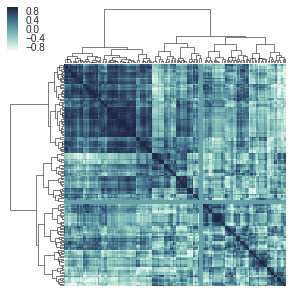

In [289]:
# Intersubject correlations (no CV loop)
sns.set(style="white")
save_figure = False

CS_cols = []
for tp in timepoints:
    CS_cols.append(cs_scale+'_'+tp)

d = pd.DataFrame(data=np.transpose(test_merge[CS_cols].values),
                 index = CS_cols,
                 columns=test_merge[col_list_feat[0]].values)

# Compute the correlation matrix
corr = d.corr()
corr = corr.fillna(0) #NAN rise from subject with constant scores over all timepoints (for MMSE)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#sns.clustermap(data=corr, annot=True, cmap='Greens')
cmap = sns.cubehelix_palette(as_cmap=True, rot=-.3, light=1)

g = sns.clustermap(corr, method='ward', cmap=cmap, figsize=(5, 5),xticklabels=False,yticklabels=False)

In [291]:
#Plot cluster memebership distribution per PTID
clust_df = test_merge[CS_cols]
subject_index_col_name = 'PTID'
similarity_metric = 'euclidean' #'euclidean' #correlation
test_dist_metric = similarity_metric
linkage_metric = 'ward'

subx = len(clust_df.index)
n_folds = 10
kf_traj_df, KF_traj_stats, KF_class_distribution = KFold_clustering_stability(clust_df,subject_index_col_name,similarity_metric,
                                                                              linkage_metric,test_dist_metric,n_folds)

traj_permute_stats = pd.DataFrame(columns=[subject_index_col_name,'train_T1_percent','train_T2_percent','train_test_check'])
for i, sub_id in enumerate(clust_df.index):    
    traj_list = kf_traj_df[(kf_traj_df[subject_index_col_name] == str(sub_id)) & (kf_traj_df['subset']=='train')]['trajectory_class'].values 
    t1_percent = int(100*np.sum(traj_list=='1')/float(len(traj_list)))
    t2_percent = int(100*np.sum(traj_list=='2')/float(len(traj_list)))
    test_traj = kf_traj_df[(kf_traj_df[subject_index_col_name] == str(sub_id)) & (kf_traj_df['subset']=='test')]['trajectory_class'].values
    train_test_check = test_traj==str(1+np.argmax([t1_percent,t2_percent]))
    traj_permute_stats.loc[i] = [sub_id,t1_percent,t2_percent,train_test_check[0]]

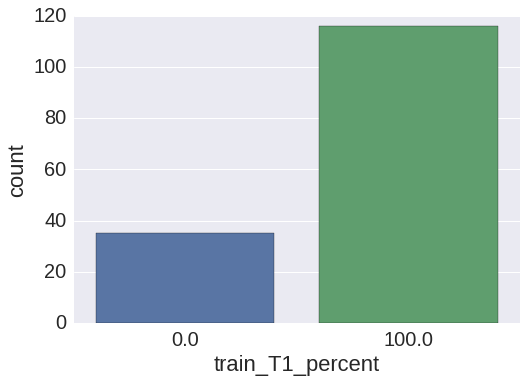

In [292]:
# Plot distribution of Traj_1 distribution  
# save_figure = False
sns.set(style="whitegrid")
sns.set(font_scale=2) 
g = sns.countplot(x = 'train_T1_percent', data=traj_permute_stats)

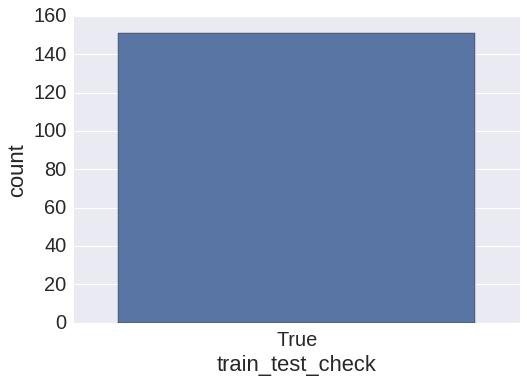

In [293]:
#Plot Count train_traj = test_traj
g = sns.countplot(x = 'train_test_check', data=traj_permute_stats)

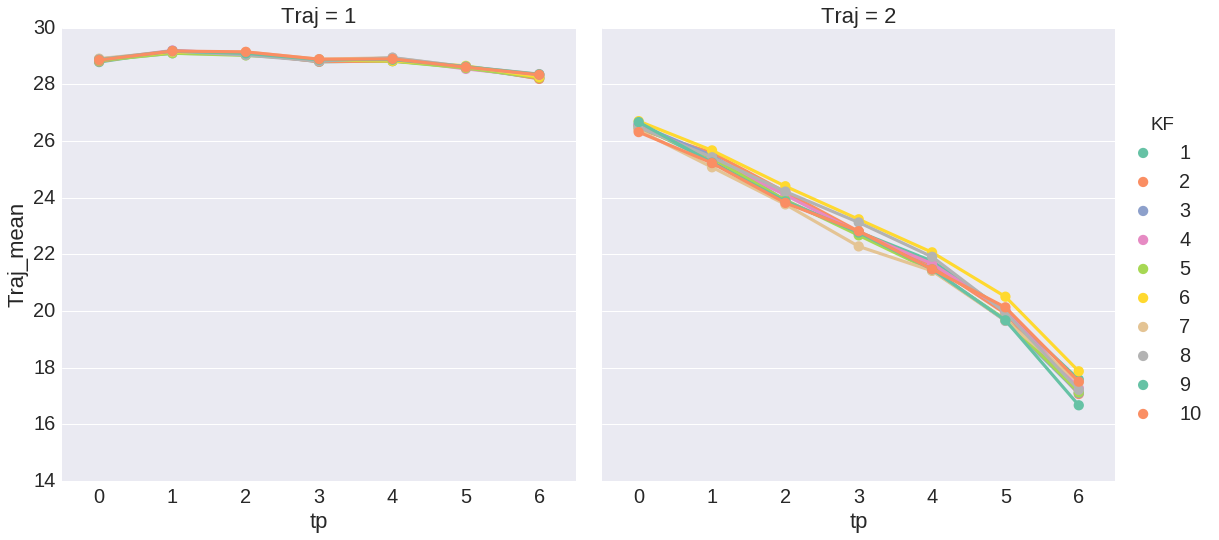

In [294]:
#Plot Trajectories over KF
KF_traj_stats_df = pd.DataFrame.from_dict(KF_traj_stats,orient='index')

sns.factorplot(y='Traj_mean', x='tp', hue='KF', kind='point', col='Traj' ,palette='Set2',data=KF_traj_stats_df,size=8)


In [278]:
KF_class_dist_df = pd.DataFrame.from_dict(KF_class_distribution,orient='index')
KF_class_dist_df

,train_T2_percent,train_T1_percent
1,33,102
2,31,105
3,31,105
4,33,103
5,33,103
6,30,106
7,29,107
8,33,103
9,30,106
10,32,104


In [313]:
for cohort in ['ADNI1','ADNI2']:
    count = []
    print cohort
    for tp in ['bl','m06','m12','m18','m24','m36']:
        for dx in ['CN','EMCI','LMCI']:
            data_slice = adnimerge_data[(adnimerge_data['ORIGPROT']==cohort)&(adnimerge_data['VISCODE']==tp)&
                                       (adnimerge_data['DX_bl']==dx)]
            count.append(len(data_slice))
            print '{},{}: {}'.format(tp,dx,len(data_slice))

    print 'total number of subjects: {}'.format(np.sum(np.array(count)))

ADNI1
bl,CN: 229
bl,EMCI: 0
bl,LMCI: 398
m06,CN: 220
m06,EMCI: 0
m06,LMCI: 381
m12,CN: 212
m12,EMCI: 0
m12,LMCI: 358
m18,CN: 211
m18,EMCI: 0
m18,LMCI: 326
m24,CN: 203
m24,EMCI: 0
m24,LMCI: 303
m36,CN: 187
m36,EMCI: 0
m36,LMCI: 260
total number of subjects: 3288
ADNI2
bl,CN: 187
bl,EMCI: 181
bl,LMCI: 164
m06,CN: 178
m06,EMCI: 159
m06,LMCI: 157
m12,CN: 175
m12,EMCI: 163
m12,LMCI: 150
m18,CN: 164
m18,EMCI: 130
m18,LMCI: 134
m24,CN: 155
m24,EMCI: 132
m24,LMCI: 123
m36,CN: 7
m36,EMCI: 36
m36,LMCI: 22
total number of subjects: 2417


In [316]:
adnimerge_data.columns

Index([u'RID', u'PTID', u'VISCODE', u'SITE', u'COLPROT', u'ORIGPROT',
       u'EXAMDATE', u'DX_bl', u'AGE', u'PTGENDER', u'PTEDUCAT', u'PTETHCAT',
       u'PTRACCAT', u'PTMARRY', u'APOE4', u'FDG', u'PIB', u'AV45', u'CDRSB',
       u'ADAS11', u'ADAS13', u'MMSE', u'RAVLT_immediate', u'RAVLT_learning',
       u'RAVLT_forgetting', u'RAVLT_perc_forgetting', u'FAQ', u'MOCA',
       u'EcogPtMem', u'EcogPtLang', u'EcogPtVisspat', u'EcogPtPlan',
       u'EcogPtOrgan', u'EcogPtDivatt', u'EcogPtTotal', u'EcogSPMem',
       u'EcogSPLang', u'EcogSPVisspat', u'EcogSPPlan', u'EcogSPOrgan',
       u'EcogSPDivatt', u'EcogSPTotal', u'Ventricles', u'Hippocampus',
       u'WholeBrain', u'Entorhinal', u'Fusiform', u'MidTemp', u'ICV', u'DX',
       u'EXAMDATE_bl', u'CDRSB_bl', u'ADAS11_bl', u'ADAS13_bl', u'MMSE_bl',
       u'RAVLT_immediate_bl', u'RAVLT_learning_bl', u'RAVLT_forgetting_bl',
       u'RAVLT_perc_forgetting_bl', u'FAQ_bl', u'Ventricles_bl',
       u'Hippocampus_bl', u'WholeBrain_bl', u'Entorhi

In [357]:
def getTrajClass(scores, traj_templates, tp_vector, similarity_metric):
    # scores: list_scores; traj_templates: score_vectors representing all tp;
    # tp_vector: selected tp_vector depending on datset (AIBL has different timepoints)
    # similarity metric: corr / euclidean 
    traj = []
    dist = []
    traj_1 = traj_templates[0,tp_vector]
    traj_2 = traj_templates[1,tp_vector]
    for score in scores:        
        if len(score) == len(tp_vector):
            if similarity_metric == 'correlation':                
                d1=stats.pearsonr(score, traj_1)[0]  
                d2=stats.pearsonr(score, traj_2)[0]  
                traj.append(1+np.argmax([d1,d2]))                

            elif similarity_metric == 'euclidean':
                d1=np.sum((score - traj_1)**2) 
                d2=np.sum((score - traj_2)**2) 
                traj.append(1+np.argmin([d1,d2]))
            else:
                print 'unknown test distance metric'
                        
            dist.append(np.abs(d1-d2))
                
        else:
            print 'Number of timepoints (score vs. template) mismatch'
    
    return traj, dist
        

In [360]:
traj_templates = np.array([[24,26,22,24,22],[22,20,16,14,10]])
tp_vector = np.arange(5)
similarity_metric = 'correlation'
scores = [np.array([22,24,22,22,22]),np.array([10,10,8,5,2])]

getTrajClass(scores, traj_templates, tp_vector, similarity_metric)

([1, 2], [0.38032011052551074, 0.36349430238878899])